# 1)Supervised Learning

In [2]:
import pandas as pd, tensorflow as tf, numpy as np
import re, contractions, nltk, statistics, string, csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Reshape, Embedding, Conv1D, GlobalMaxPooling1D, Dense, MaxPooling1D, Dropout, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_hub as hub
from bert import tokenization
import transformers
import tokenizers
import warnings

warnings.filterwarnings("ignore", category=ResourceWarning)

In [3]:
!pip install contractions
!pip install bert-tensorflow
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df = pd.read_csv('IMDB Dataset.csv', encoding='utf-8', engine='python', error_bad_lines=False)

<ipython-input-5-e58b37207f20>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('IMDB Dataset.csv', encoding='utf-8', engine='python', error_bad_lines=False)


In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.shape

(50000, 2)

In [8]:
df.iloc[0]

review       One of the other reviewers has mentioned that ...
sentiment                                             positive
Name: 0, dtype: object

In [9]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [10]:
print(df.sentiment.value_counts())

positive    25000
negative    25000
Name: sentiment, dtype: int64


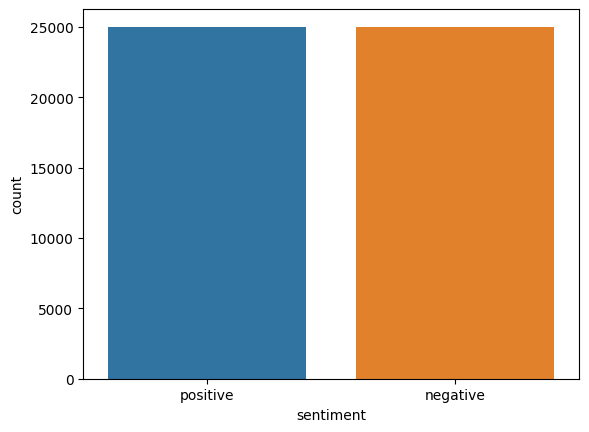

In [11]:
sns.countplot(x='sentiment', data=df)
plt.show()

In [12]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [14]:
sentiment_label = {"positive": 1, "negative": 0}
df["sentiment"] = df["sentiment"].map(sentiment_label)

In [15]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [16]:
word_counts = df['review'].apply(lambda x: len(x.split()))
print(f'Maximum number of words before cleaning : {word_counts.max()}')
print(f'Minimum number of words before cleaning : {word_counts.min()}')

Maximum number of words before cleaning : 2470
Minimum number of words before cleaning : 4


In [17]:
print(f'Longest : \n{max(df["review"], key=len)}')
print(f'\nShortest : \n{min(df["review"], key=len)}')

Longest : 
Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the

In [18]:
median_review = statistics.median(word_counts)
mean_review = statistics.mean(word_counts)

Q1,Q3 = np.percentile(word_counts, [25,75])

IQR = Q3 - Q1
upper_limit = Q3+1.5*IQR
lower_limit = Q1-1.5*IQR

print(f'Median of reviews length is {median_review}\nMean of reviews length is {mean_review:.2f}')
print(f'Interquartile range is {IQR}')
print(f'The quartile 1 is {Q1} and quartile 3 is {Q3}')
print(f'\nLower limit for outliers is {lower_limit}\nUpper limit for outliers is {upper_limit}')

Median of reviews length is 173.0
Mean of reviews length is 231.16
Interquartile range is 154.0
The quartile 1 is 126.0 and quartile 3 is 280.0

Lower limit for outliers is -105.0
Upper limit for outliers is 511.0


In [19]:
df = df[df['review'].apply(lambda x: len(x.split())) <= upper_limit]

In [20]:
print(df.shape)

(46292, 2)


In [21]:
word_counts = df['review'].apply(lambda x: len(x.split()))
print(f'Maximum number of words after droping : {word_counts.max()}')
print(f'Minimum number of words after droping : {word_counts.min()}')

Maximum number of words after droping : 511
Minimum number of words after droping : 4


In [22]:
df_pos = df[df['sentiment'] == 1][:5000]
df_neg = df[df['sentiment'] == 0][:5000]

df_new = pd.concat([df_pos, df_neg])

df_new = df_new.sample(frac=1).reset_index(drop=True) # Shuffle rows

print(df_new['sentiment'].value_counts())

1    5000
0    5000
Name: sentiment, dtype: int64


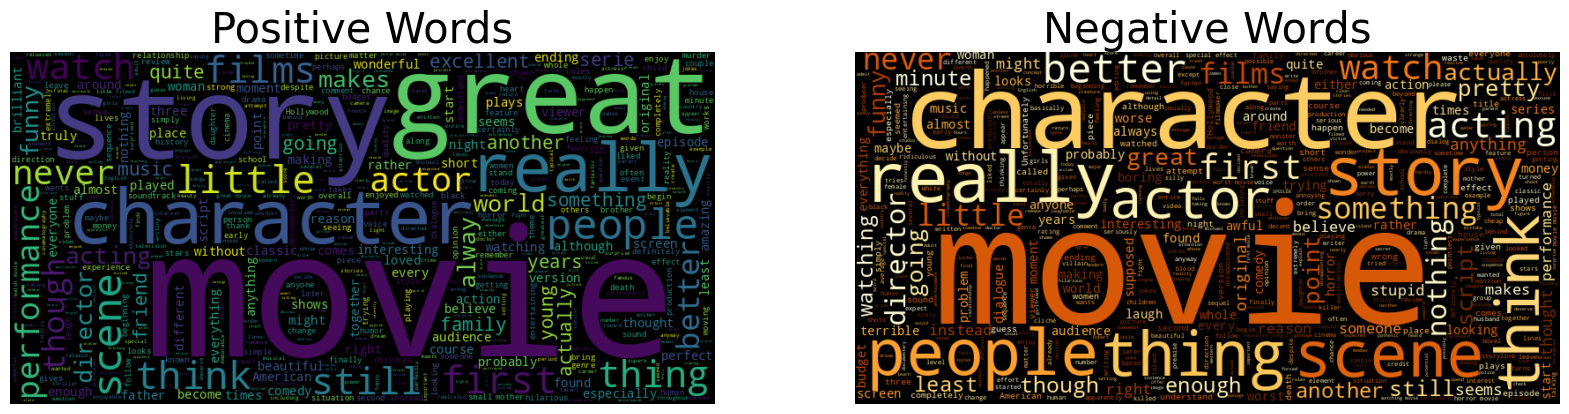

In [23]:
positive_words = " ".join(df_new[df_new.sentiment == 1].review)
positive_wordcloud = WordCloud(max_words=500, width=800, height=400, min_word_length=5).generate(positive_words)

negative_words = " ".join(df_new[df_new.sentiment == 0].review)
negative_wordcloud = WordCloud(max_words=500, width=800, height=400, colormap="YlOrBr", min_word_length=5).generate(negative_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.set_title('Positive Words', fontsize=30)
ax1.axis('off')

ax2.imshow(negative_wordcloud, interpolation='bilinear', cmap='YlOrBr')
ax2.set_title('Negative Words', fontsize=30)
ax2.axis('off')

plt.show()

In [24]:
emoji_pattern = re.compile('['
    '\U0001F1E0-\U0001F1FF'  # flags (iOS)
    '\U0001F300-\U0001F5FF'  # symbols & pictographs
    '\U0001F600-\U0001F64F'  # emoticons
    '\U0001F680-\U0001F6FF'  # transport & map symbols
    '\U0001F700-\U0001F77F'  # alchemical symbols
    '\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
    '\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
    '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
    '\U0001FA00-\U0001FA6F'  # Chess Symbols
    '\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
    '\U00002702-\U000027B0'  # Dingbats
    '\U000024C2-\U0001F251'
    ']+')

In [25]:
lemmatizer = WordNetLemmatizer()
negative_words = ["no", "not", "didn't","mustn't","weren't","shan't","any","wouldn't","won't","wasn't","but","isn't","aren't","haven't","not","couldn't","don't","hadn't","shouldn't","mightn't","no","needn't","doesn't","hasn't"]

For this dataset when we remove stop words and use contractions and lemmatizer or stemming, its accuracy go higer therefore we didn't use them

In [26]:
def preprocessing(data):
    data = data.lower() # lowercase
    data = emoji_pattern.sub(r'',data) # remove emojis
    data = re.sub(r'https://\S+|www\.\S+','',data) # remove URLs
    data = re.sub(r'\([^)]*\)|\[[^\]]*\]|<.*?>|\\','', data) # remove parentheses and square brackets and html tags
    data = word_tokenize(data)
    data = [contractions.fix(word) for word in data]
    data = [re.sub(r'[^\w\s]+', '', word) for word in data] # remove punctuation
    stopwords_list = set(stopwords.words('english'))
    stopwords_list.difference_update(negative_words)
    data = [word for word in data if word not in stopwords_list]
    data = [lemmatizer.lemmatize(word) for word in data]
    data = ['not' if word == 'nt' else word for word in data]
    data = ' '.join(data)
    data = data.strip()
    return data

In [27]:
# def preprocess_and_tokenize(data):
#     data = data.apply(preprocessing)
#     print(data[0])
#     tokenizer = Tokenizer(num_words=5000)
#     tokenizer.fit_on_texts(data)
#     data = tokenizer.texts_to_sequences(data)
#     data = pad_sequences(data, padding='post', maxlen=500) # length of the longest sentence 500
#     return data

In [28]:
X = df_new['review']
y = df_new['sentiment']

In [29]:
X_new = X.apply(preprocessing)
y_new = y.copy()

In [30]:
X[0]

"I remember seeing this film in the theater in 1984 when I was 6 years-old (you do the math). I absolutely loved it. I was Tarzan for the 2 weeks after seeing it (climbing the furniture, jumping around making monkey sounds). It started a fascination with Tarzan and monkeys, but oddly enough a longer lasting love for Christopher Lambert (keep in mind that I saw Highlander very shortly after this). 1984 was the last time I saw that film, until about a month ago. It happened to be on cable as I was getting ready for bed at 3:30 am and even though it was late and I was tired and I had to be at work at 9:00 am, I stayed up to watch this movie that I loved as a kid. <br /><br />Upon viewing it I realized that it was not that great of a film and even odder then that, that Andie MacDowell's voice was dubbed by someone else. Ian Holme was of course solid as usual, and surprisingly the monkey suits still kind of held up, but what was most surprising was how good Lambert was as Tarzan. He was gre

In [31]:
X_new[200]

'watched show  cousin  hate  first  girl dress style clothes  first letter name  villain  first monkey part brain showing  version devil  pink hillbilly  gang green gang spoiled princess among others  also found no male hero show   would rather watch sailor moon  much better  someone else want watch show room  are  find way break television  believe   will save half hour torturerating  giving deserves  1 10 whatever  not watch'

In [32]:
y_new[200]

0

In [33]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42, stratify=y_new)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42, stratify=y_train_valid)

In [34]:
print(f'Train set: {X_train.shape}, {y_train.shape}')
print(f'Valid set: {X_valid.shape}, {y_valid.shape}')
print(f'Test set : {X_test.shape}, {y_test.shape}')

Train set: (6400,), (6400,)
Valid set: (1600,), (1600,)
Test set : (2000,), (2000,)


In [35]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [36]:
X_train_tfidf.shape

(6400, 2000)

In [37]:
X_train_tfidf[200]

<1x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 35 stored elements in Compressed Sparse Row format>

In [38]:
X_train_tfidf.shape[1]

2000

In [39]:
X_train_tfidf_arr = X_train_tfidf.toarray()
X_valid_tfidf_arr = X_valid_tfidf.toarray()
X_test_tfidf_arr = X_test_tfidf.toarray()

In [40]:
inputs = Input(shape=(X_train_tfidf_arr.shape[1],))
layer = Embedding(input_dim=5000, output_dim=32, input_length=X_train_tfidf_arr.shape[1])(inputs)
layer = Conv1D(filters=32, kernel_size=3, activation='relu')(layer)
layer = MaxPooling1D(pool_size=2)(layer)
layer = Conv1D(filters=64, kernel_size=3, activation='relu')(layer)
layer = GlobalMaxPooling1D()(layer)
layer = Dense(units=64, activation='relu')(layer)
layer = Dropout(rate=0.5)(layer)
layer = Reshape(target_shape=(1, -1))(layer)
layer = LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)(layer)
output = Dense(units=1, activation='sigmoid')(layer)

supervised_model = Model(inputs=inputs, outputs=output)

In [41]:
supervised_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 embedding (Embedding)       (None, 2000, 32)          160000    
                                                                 
 conv1d (Conv1D)             (None, 1998, 32)          3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 999, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 997, 64)           6208      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                              

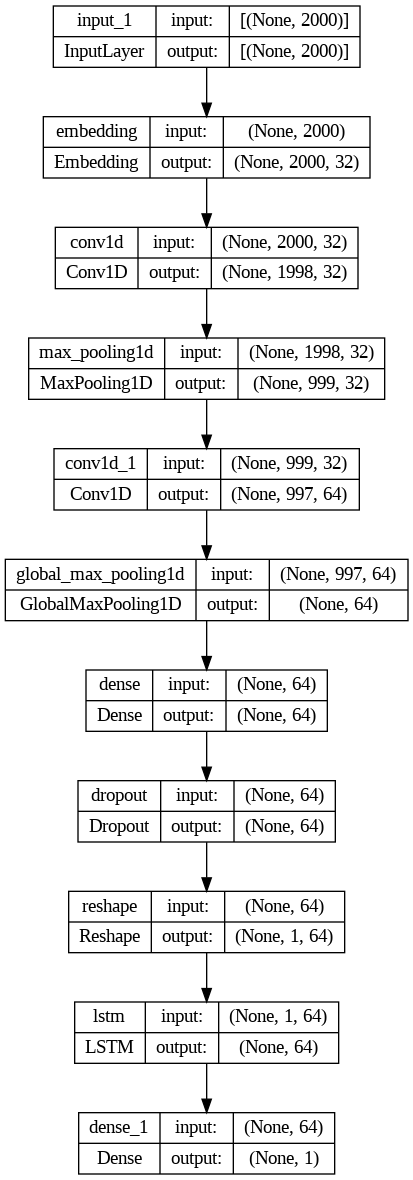

In [42]:
plot_model(supervised_model, to_file='supervised_model.png', show_shapes=True, show_layer_names=True)

In [43]:
supervised_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [45]:
supervised_history = supervised_model.fit(X_train_tfidf_arr, y_train, batch_size=64, epochs=5, validation_data=(X_valid_tfidf_arr, y_valid), callbacks=[early_stop, checkpoint])

Epoch 1/5
100/100 [==============================] - 36s 325ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
100/100 [==============================] - 37s 372ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
100/100 [==============================] - 32s 319ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
100/100 [==============================] - 32s 320ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.5000


In [46]:
supervised_model.save('supervised_model.h5')

In [47]:
loss_supervised, accuracy_supervised = supervised_model.evaluate(X_test_tfidf_arr, y_test, batch_size=64)

print(f'Loss on Test    :\t {loss_supervised:.3f}')
print(f'Accuracy on Test:\t {accuracy_supervised:.3f}')

32/32 [==============================] - 2s 61ms/step - loss: 0.6932 - accuracy: 0.5000
Loss on Test    :	 0.693
Accuracy on Test:	 0.500


In [48]:
predictions_supervised = supervised_model.predict(X_test_tfidf_arr, batch_size=64)
y_pred_supervised = (predictions_supervised > 0.5).astype(int)

32/32 [==============================] - 2s 58ms/step


In [49]:
print("Original     Predicted")
print("======================")
for i in range(5):
    print('   ',y_test.iloc[i],'\t\t', y_pred_supervised[i][0])

Original     Predicted
    0 		 0
    1 		 0
    0 		 0
    1 		 0
    0 		 0


# 2) Unsupervised Learning

In [50]:
input_layer = Input(shape=(X_train_tfidf_arr.shape[1],))
encoder = Dense(256, activation='relu')(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(128, activation='relu')(encoder)
decoder = Dense(256, activation='relu')(encoder)
decoder = Dropout(0.2)(decoder)
decoder = Dense(X_train_tfidf_arr.shape[1], activation='sigmoid')(decoder)
autoencoder_model = Model(inputs=input_layer, outputs=decoder)

In [51]:
autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense_2 (Dense)             (None, 256)               512256    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2000)              5140

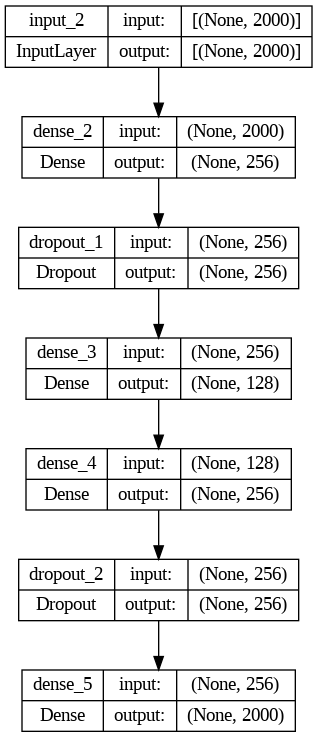

In [52]:
plot_model(autoencoder_model, to_file='autoencoder_model.png', show_shapes=True, show_layer_names=True)

In [53]:
autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy')

In [54]:
autoencoder_history = autoencoder_model.fit(X_train_tfidf_arr, X_train_tfidf_arr, batch_size=64, epochs=5, validation_data=(X_valid_tfidf_arr, X_valid_tfidf_arr), callbacks=[early_stop])

Epoch 1/5
100/100 [==============================] - 4s 28ms/step - loss: 0.1445 - val_loss: 0.0228
Epoch 2/5
100/100 [==============================] - 4s 39ms/step - loss: 0.0229 - val_loss: 0.0224
Epoch 3/5
100/100 [==============================] - 3s 31ms/step - loss: 0.0221 - val_loss: 0.0214
Epoch 4/5
100/100 [==============================] - 3s 26ms/step - loss: 0.0214 - val_loss: 0.0211
Epoch 5/5
100/100 [==============================] - 3s 26ms/step - loss: 0.0212 - val_loss: 0.0210


In [55]:
autoencoder_model.save('autoencoder_model.h5')

In [56]:
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_features = encoder_model.predict(X_train_tfidf_arr)
X_val_features = encoder_model.predict(X_valid_tfidf_arr)
X_test_features = encoder_model.predict(X_test_tfidf_arr)

63/63 [==============================] - 0s 3ms/step


In [57]:
X_train_features[0][:5]

array([0.3693751 , 0.05963147, 0.4511303 , 0.14249091, 1.0002248 ],
      dtype=float32)

In [58]:
# Supervised model
inputs_encoded = Input(shape=(128,))
layer_encoded = Dense(units=64, activation='relu')(inputs_encoded)
layer_encoded = Dropout(rate=0.5)(layer_encoded)
output_encoded = Dense(units=1, activation='sigmoid')(layer_encoded)
supervised_model_encoded = Model(inputs=inputs_encoded, outputs=output_encoded)

In [59]:
supervised_model_encoded.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
history_supervised_encoded = supervised_model_encoded.fit(X_train_features, y_train, batch_size=64, epochs=10, validation_data=(X_val_features, y_valid), callbacks=[early_stop])

Epoch 1/10
100/100 [==============================] - 1s 6ms/step - loss: 0.7045 - accuracy: 0.5022 - val_loss: 0.6922 - val_accuracy: 0.5263
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5102 - val_loss: 0.6925 - val_accuracy: 0.5169
Epoch 3/10
100/100 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5077 - val_loss: 0.6925 - val_accuracy: 0.5044
Epoch 4/10
100/100 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5095 - val_loss: 0.6922 - val_accuracy: 0.5450
Epoch 5/10
100/100 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5098 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
100/100 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4961 - val_loss: 0.6930 - val_accuracy: 0.5181
Epoch 7/10
100/100 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6929 - val_accuracy: 0.5000


In [61]:
loss_unsupervised, accuracy_unsupervised = supervised_model_encoded.evaluate(X_test_features, y_test, batch_size=64)

print(f'Loss on Test    :\t {loss_unsupervised:.3f}')
print(f'Accuracy on Test:\t {accuracy_unsupervised:.3f}')

32/32 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5000
Loss on Test    :	 0.693
Accuracy on Test:	 0.500


In [62]:
predictions_unsupervised = supervised_model_encoded.predict(X_test_features, batch_size=64)
y_pred_unsupervised = (predictions_unsupervised > 0.5).astype(int)

32/32 [==============================] - 0s 1ms/step


In [63]:
print("Original     Predicted")
print("======================")
for i in range(5):
    print('   ',y_test.iloc[i],'\t\t', y_pred_unsupervised[i][0])

Original     Predicted
    0 		 1
    1 		 1
    0 		 1
    1 		 1
    0 		 1


Because Low Accuracy we wanted to use GAN but its accuracy didn't increase

In [64]:
# def define_generator(latent_dim, n_words, max_length):
#     input_layer = Input(shape=(latent_dim,))
#     embedding_layer = Embedding(input_dim=n_words, output_dim=128, input_length=max_length)(input_layer)
#     lstm_layer = LSTM(128)(embedding_layer)
#     dropout_layer = Dropout(0.2)(lstm_layer)
#     output_layer = Dense(max_length, activation='linear')(dropout_layer)
#     model = Model(input_layer, output_layer)
#     return model

In [65]:
# def define_discriminator(n_words, max_length):
#     input_layer = Input(shape=(max_length,))
#     embedding_layer = Embedding(input_dim=n_words, output_dim=128, input_length=max_length)(input_layer)
#     conv_layer = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding_layer)
#     pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
#     lstm_layer = LSTM(128)(pooling_layer)
#     dropout_layer = Dropout(0.2)(lstm_layer)
#     output_layer = Dense(1, activation='sigmoid')(dropout_layer)
#     model = Model(input_layer, output_layer)
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     return model

In [66]:
# def define_gan(generator, discriminator):
#     discriminator.trainable = True
#     input_layer = Input(shape=(latent_dim,))
#     generated_reviews = generator(input_layer) # Fake reviews 
#     validity = discriminator(generated_reviews)
    
#     model = Model(input_layer, validity)
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
#     model.compile(loss='binary_crossentropy', optimizer=optimizer)
#     return model

In [67]:
# # Hyperparameters
# latent_dim = 100
# n_words = 5000
# max_length = 500
# batch_size = 64
# epochs = 100

In [68]:
# generator = define_generator(latent_dim, n_words, max_length)
# discriminator = define_discriminator(n_words, max_length)
# gan = define_gan(generator, discriminator)

In [69]:
# def generate_noise(n_samples, latent_dim):
#     x = np.random.normal(0, 1, size=(n_samples, latent_dim))
#     return x.reshape((n_samples, latent_dim))

In [70]:
# for epoch in range(epochs):
#     noise = generate_noise(batch_size, latent_dim)
#     fake_reviews = generator.predict(noise)

#     idx = np.random.randint(0, X_train.shape[0], batch_size)
#     real_reviews = X_train[idx]
    
#     # reshape labels to match the shape of the predictions
#     real_labels = np.ones((batch_size, 1))
#     fake_labels = np.zeros((batch_size, 1))

#     discriminator_loss_real = discriminator.train_on_batch(real_reviews, real_labels)
#     discriminator_loss_fake = discriminator.train_on_batch(fake_reviews, fake_labels)
#     discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

#     noise = generate_noise(batch_size, latent_dim)
#     gan_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

#     if epoch % 10 == 0:
#         print("Epoch: %d, Discriminator Loss: %f, Discriminator Accuracy: %.2f%%, GAN Loss: %f" % 
#               (epoch, discriminator_loss[0], 100 * discriminator_loss[1], gan_loss))

# 3) Pre_trained

In [71]:
print(X_new[0])
print(y_new[0])

remember seeing film theater 1984 6 yearsold  absolutely loved  tarzan 2 week seeing  started fascination tarzan monkey  but oddly enough longer lasting love christopher lambert  1984 last time saw film  month ago  happened cable getting ready bed 330 even though late tired work 900  stayed watch movie loved kid  upon viewing realized not great film even odder  andie macdowell voice dubbed someone else  ian holme course solid usual  surprisingly monkey suit still kind held  but surprising good lambert tarzan  great  depth managed capture line  primal body language importantly ability bring character extremely large ark  amazingas stated earlier lambert fan  but used highlander  hunted fortress  film really quite good shame never got chance portray character depth againso make short story way long  little disappointed film not good  but glad see lambert good not regret staying 600am see
1


In [72]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42, stratify=y_new)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42, stratify=y_train_valid)

In [73]:
print(f'Train set: {X_train.shape}, {y_train.shape}')
print(f'Valid set: {X_valid.shape}, {y_valid.shape}')
print(f'Test set : {X_test.shape}, {y_test.shape}')

Train set: (6400,), (6400,)
Valid set: (1600,), (1600,)
Test set : (2000,), (2000,)


In [74]:
X_train.iloc[200]

'show absolutely fantastic  provides great drama romance teen show like oc dawson  but whole lot funnier  show moral value  without everything sugar coated sanitised not sorority fraternity australia  university system completely different  no idea accurately greek life portrayed  but not care  show new favourite  any writer make love racist  homophobe confederate flagwaving bible basher must geniusand cappie new pacey  sorry josh jackson  dethroned'

In [75]:
y_train.iloc[200]

1

In [76]:
type(X_train)

pandas.core.series.Series

In [77]:
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [78]:
print(word_index)

{'<oov>': 1, 'not': 2, 'movie': 3, 'film': 4, 'but': 5, 'one': 6, 'like': 7, 'would': 8, 'good': 9, 'time': 10, 'character': 11, 'story': 12, 'get': 13, 'see': 14, 'even': 15, 'make': 16, 'really': 17, 'no': 18, 'great': 19, 'scene': 20, 'well': 21, 'much': 22, 'could': 23, 'bad': 24, 'show': 25, 'people': 26, 'also': 27, 'first': 28, 'way': 29, 'made': 30, 'watch': 31, 'thing': 32, 'think': 33, 'any': 34, 'go': 35, 'love': 36, 'acting': 37, 'life': 38, 'plot': 39, 'actor': 40, 'seen': 41, 'many': 42, 'know': 43, 'never': 44, 'best': 45, 'little': 46, 'look': 47, 'say': 48, 'ever': 49, 'better': 50, 'year': 51, 'end': 52, 'two': 53, 'still': 54, 'come': 55, 'give': 56, 'take': 57, 'want': 58, 'work': 59, 'lot': 60, 'watching': 61, 'something': 62, 'man': 63, 'funny': 64, 'performance': 65, 'part': 66, 'real': 67, 'find': 68, 'director': 69, 'guy': 70, 'back': 71, 'play': 72, 'nothing': 73, 'woman': 74, 'though': 75, 'actually': 76, 'got': 77, 'every': 78, 'old': 79, 'going': 80, 'prett

In [79]:
vocab = len(word_index)
print(f"Number of Vocabulary in dataset : {vocab}")

Number of Vocabulary in dataset : 45617


In [80]:
seq_train = tokenizer.texts_to_sequences(X_train)
seq_valid = tokenizer.texts_to_sequences(X_valid)
seq_test =  tokenizer.texts_to_sequences(X_test)

In [81]:
seq_len_list = [len(i) for i in seq_train + seq_test]

max_len = max(seq_len_list)
print(f'Maximum length of sequence in the list: {max_len}')

Maximum length of sequence in the list: 305


In [82]:
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print(f'Maximum length of the sequence with two standard deviations: {max_seq_len}')

Maximum length of the sequence with two standard deviations: 203


In [83]:
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [84]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

In [85]:
def tokenize_data(data):
  encoded_data = tokenizer(data.tolist(), max_length=max_seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='np')
  return encoded_data

In [86]:
X_train_enc = tokenize_data(X_train)
X_valid_enc = tokenize_data(X_valid)
X_test_enc = tokenize_data(X_test)

In [87]:
#Preparing datasets
def prepare_dataset(x, y):
  data_enc = tf.data.Dataset.from_tensor_slices((dict(x), y))
  return data_enc

train_dataset = prepare_dataset(X_train_enc, y_train)
val_dataset = prepare_dataset(X_valid_enc, y_valid)
test_dataset = prepare_dataset(X_test_enc, y_test)

In [88]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
epochs = 1
max_len = max_seq_len

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [89]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask')
sequence_output = transformer(input_ids,attention_mask)[0]
cls_token = sequence_output[:, 0, :]
layer = Dense(512, activation='relu')(cls_token)
layer = Dropout(0.1)(layer)
output_layer = Dense(1, activation='sigmoid')(layer)
bert_model = Model(inputs=[input_ids,attention_mask], outputs=output_layer)

In [90]:
bert_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 203)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 203)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 203, 768),                                                   
                                 hidden_states=None                                         

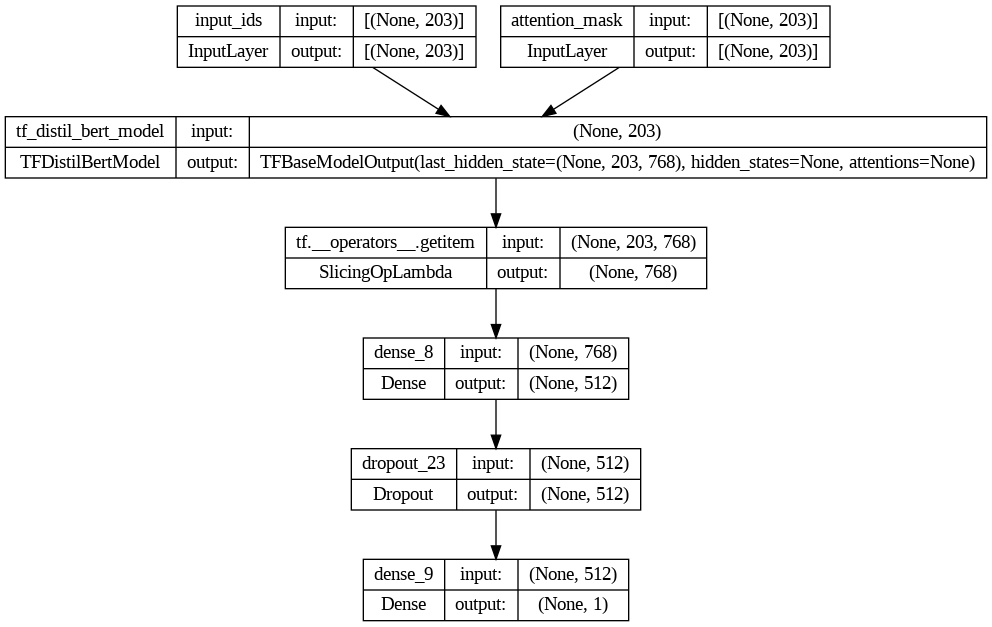

In [91]:
plot_model(bert_model, to_file='bert_model.png', show_shapes=True, show_layer_names=True)

In [92]:
bert_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [93]:
history_bert = bert_model.fit(train_dataset.batch(64), validation_data = val_dataset.batch(64),epochs = epochs, callbacks=[early_stop])

100/100 [==============================] - 9553s 95s/step - loss: 0.7697 - accuracy: 0.5056 - val_loss: 0.6932 - val_accuracy: 0.5000
